In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [4]:
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")

X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


/tmp/ipykernel_31930/3053175696.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


In [15]:
clean = cleaning_pipeline()
prep  = preprocessing_pipeline() 

tree_clf = Pipeline([
    ("clean", clean),
    ("prep", prep),
    ("tree_clf", DecisionTreeClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

cv_result_base = cross_validate(
    tree_clf,
    X_train,
    y_train,
    scoring = scoring,
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

#rate
cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_metric_base = {**cv_base_metrics_mean, **cv_base_metrics_std}
pd.DataFrame([cv_metric_base])


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.67635,0.652899,0.652528,0.65218,0.652899,0.004198,0.005901,0.005226,0.004594,0.005901


In [16]:
#Trening na X_test
tree_clf.fit(X_train, y_train)

y_pred_base = tree_clf.predict(X_test)

test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.68445,0.659851,0.660589,0.661351,0.659851


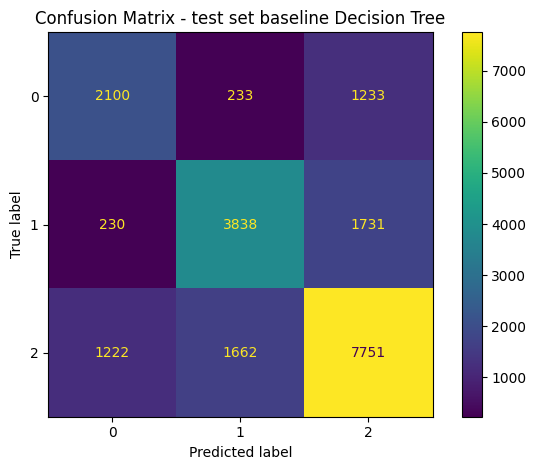

In [13]:
cm = confusion_matrix(y_test, y_pred_base)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline Decision Tree")
plt.tight_layout()
plt.show()

In [14]:
with mlflow.start_run(run_name="Decision_Tree_baseline"):
    # 1.Metrics CV
    mlflow.log_metrics(cv_metric_base)
    # 2.Metrics TEST
    mlflow.log_metrics(test_metrics_base)

🏃 View run Decision_Tree_baseline at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/ab016cf630524ef097b2553474e5b0a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966


Tuned

In [18]:
params_distributions = {
    "tree_clf__max_depth": [3, 5, 7, 9, 12, None],
    "tree_clf__min_samples_split": [2, 20, 50, 100, 200],
    "tree_clf__min_samples_leaf": [1, 5, 10, 20, 50],
    "tree_clf__criterion": ["gini", "entropy"],
    "tree_clf__class_weight": [None, "balanced"],
    "tree_clf__max_features": [None, "sqrt", "log2", 0.5],
    "tree_clf__max_leaf_nodes": [None, 50, 100, 200, 500]
}

random_search = RandomizedSearchCV(
    estimator=tree_clf,
    param_distributions=params_distributions,
    n_iter=30,
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1,
    return_train_score=False
    
)

random_search.fit(X_train, y_train)

best_tree_clf = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

In [19]:
cv_result_tuned = cross_validate(
    best_tree_clf,
    X_train,
    y_train,
    scoring = scoring,
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

cv_tuned_metrics_mean = {
    f"cv_{metrics}_mean_tuned": float(cv_result_tuned[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_tuned_metrics_std = {
    f"cv_{metrics}_std_tuned": float(cv_result_tuned[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_metric_tuned = {**cv_tuned_metrics_mean, **cv_tuned_metrics_std}

pd.DataFrame([cv_metric_tuned])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

,cv_accuracy_mean_tuned,cv_balanced_accuracy_mean_tuned,cv_f1_macro_mean_tuned,cv_precision_macro_mean_tuned,cv_recall_macro_mean_tuned,cv_accuracy_std_tuned,cv_balanced_accuracy_std_tuned,cv_f1_macro_std_tuned,cv_precision_macro_std_tuned,cv_recall_macro_std_tuned
0,0.70635,0.689602,0.685088,0.683492,0.689602,0.001604,0.004297,0.001784,0.002356,0.004297


In [20]:
y_pred_tuned = best_tree_clf.predict(X_test)

test_metrics_tuned = {
    "test_accuracy": accuracy_score(y_test, y_pred_tuned),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_tuned),
    "test_f1_macro": f1_score(y_test, y_pred_tuned, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_tuned, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_tuned, average="macro"),
}

pd.DataFrame([test_metrics_tuned])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.7085,0.687087,0.685157,0.685967,0.687087


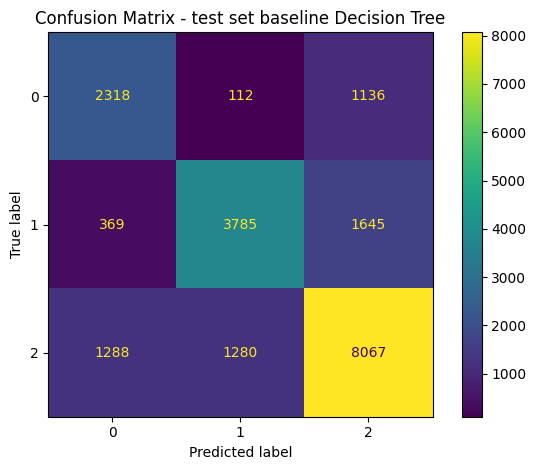

In [22]:
cm = confusion_matrix(y_test, y_pred_tuned)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline Decision Tree")
plt.tight_layout()
plt.show()

In [23]:
with mlflow.start_run(run_name="Decision_Tree_tuned"):
    mlflow.log_metrics(cv_metric_tuned)
    mlflow.log_metrics(test_metrics_tuned)
    mlflow.log_params(best_params)

🏃 View run Decision_Tree_tuned at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/3097df8247a54843b8318652a2058fe4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966
